(time_performance)=
# Time Performance

This notebook shows the performance of different methods in infomeasure.
Time complexity of H, MI, and TE is relevant when scaling up the dataset size.
As each approach is processing the data differently, this notebook looks at each approach separately.

First, this notebook prepares example data to be used with all measures.
Then, for each entropy, mutual information and transfer entropy, this notebook measures the execution time over several runs.
`benchmark_approach()` makes sure that each approach is executed 10 times.
This way we have a good estimate of the time complexity, and we can show the standard deviation of the execution time.
Finally, all three plots are united into a comparison plot.
Times are collected using the python native {py:mod}`timeit` module.

The benchmarks in this notebook have been run on a M4 Pro, sequentially on **only one core**. This way, parallelization is still possible on the user's side.
If you want to run these benchmarks on your own system, modify the parameters of the example data,
to match your system's specifications.
Before scaling up, it is recommended to first run the benchmarks on a smaller dataset, as for each H, MI, and TE.
Our measured and plotted results can be downloaded: {download}`time_data.pkl`.
At the end of this page, you can see how to load in the data.

In [1]:
import time  # for measuring elapsed time
import timeit  # for benchmarking

import matplotlib.pyplot as plt
import numpy as np
import progressbar

import infomeasure as im

## Prepare Data

- H: Gaussian data with mean 0 and standard deviation 10.
- MI: Multivariate Gaussian data with mean 0 and covariance matrix
  $
  I = \begin{bmatrix}
   10 & \rho \\
   \rho  & 10
  \end{bmatrix}, \rho = 6
  $.
- TE: $X$ from H and for $Y$, $X_i = Y_{i+1}$ for $i = 1, \ldots, N-1$.

In [2]:
def generate_data_h(N, mean=0, std=10):
    return rng.normal(mean, std, N)

In [3]:
def generate_data_mi(N, cov_matrix=[[10, 6], [6, 10]]):
    data = rng.multivariate_normal([0, 0], cov_matrix, N)
    X = data[:, 0]
    Y = data[:, 1]
    return X, Y

In [4]:
# Generate the data for different lengths of sequences
data_lengths = [
    2**k for k in range(3, 25)
]  # reduce for testing. Needs to be increasing lengths
rng = np.random.default_rng(925847)

data_h = [generate_data_h(N) for N in data_lengths]
data_mi = [generate_data_mi(N) for N in data_lengths]
data_te = [(var, np.roll(var, 1)) for var in data_h]

# discrete versions for the discrete approach
data_h_discrete = [var.astype(int) for var in data_h]
data_mi_discrete = [(var[0].astype(int), var[1].astype(int)) for var in data_mi]
data_te_discrete = [(var[0].astype(int), var[1].astype(int)) for var in data_te]
print(f"Shortest sequence length: {min(data_lengths)}")
print(f"Longest sequence length: {max(data_lengths):e}")

Shortest sequence length: 8
Longest sequence length: 1.677722e+07


The following combinations are used for the analysis.
This dictionary will also be used to store the runtime results and later to plot the results.

In [5]:
combinations = {
    "discrete": {"approach": "discrete", "kwargs": {}},
    "kernel(box)": {
        "approach": "kernel",
        "kwargs": {"bandwidth": 0.5, "kernel": "box"},
    },
    "kernel(gaussian)": {
        "approach": "kernel",
        "kwargs": {"bandwidth": 0.5, "kernel": "gaussian"},
    },
    "metric": {"approach": "metric", "kwargs": {"k": 4, "minkowski_p": np.inf}},
    "ordinal($d$=3)": {"approach": "ordinal", "kwargs": {"embedding_dim": 3}},
    "ordinal($d$=8)": {"approach": "ordinal", "kwargs": {"embedding_dim": 3}},
    r"renyi($\alpha$=1)": {"approach": "renyi", "kwargs": {"alpha": 1}},
    r"renyi($\alpha$=1.5)": {"approach": "renyi", "kwargs": {"alpha": 1.5}},
    "tsallis($q$=1.05)": {"approach": "tsallis", "kwargs": {"q": 1.05}},
    # 'miller-madow': {'approach': 'miller_madow', 'kwargs': {}},
    # r'bayes($\alpha$=0.5)': {'approach': 'bayes', 'kwargs': {'alpha': 0.5}},
    # 'shrinkage': {'approach': 'shrink', 'kwargs': {}},
    # 'grassberger': {'approach': 'grassberger', 'kwargs': {}},
    # 'chao_wang_jost': {'approach': 'chao_wang_jost', 'kwargs': {}},
    # 'ansb(K=N/100)': {'approach': 'ansb', 'kwargs': {'undersampled': np.inf}},
    # 'nsb(K=N/100)': {'approach': 'nsb', 'kwargs': {}},
    # 'zhang': {'approach': 'zhang', 'kwargs': {}},
    # 'bonachela': {'approach': 'bonachela', 'kwargs': {}},
}

## Timing Performance

We'll write benchmarking function using `timeit`.
This will help us measure how long each approach takes to compute on a given dataset.
We'll use this function to compare different approaches and see which one performs best.
The utility function allows us to provide a function, parameters, and repetitions.
Later, we can extract the mean and standard deviation for each approach and show it in the plot.

In [6]:
def benchmark_approach(
    func, *data, repetitions=10, **params
):
    """Run function and return execution times.

    Dynamically decides the number of repetitions based on available time.
    Using {module}`timeit` to measure the execution time.

    Parameters
    ----------
    func : callable
        Function to benchmark.
    *data : iterable
        Arguments to pass to the function.
    params : dict
        Keyword arguments to pass to the function.
    repetitions : int, optional (default=100)
        Repetitions to run the function.
    """
    times = []

    for _ in range(repetitions):
        # Run the function and measure time
        timer = timeit.Timer(lambda: func(*data, **params))
        times.append(timer.timeit(number=1))

    return np.array(times)

### Entropy calculation

For each approach in the `combinations` dictionary, our benchmarking function will run {py:func}`im.entropy <infomeasure.entropy>`.
This is done for each dataset in the `data` list.
As the data length is increasing, the loop stops, if the current benchmarking time exceeds `benchmark_max_time`.
Then mean and standard deviation of the benchmarking times are calculated and stored as results in the `combinations` dictionary.

In [7]:
benchmark_max_time = 400  # if exceeded, stop benchmarking current approach
total_keys = len(combinations)

# Create a progress bar for the outer loop with customized widgets
widgets = [
    progressbar.DynamicMessage("key"),
    " |",
    progressbar.Bar(),
    " | ",
    progressbar.Percentage(),
    " (",
    progressbar.ETA(),
    ")",
]

with progressbar.ProgressBar(max_value=total_keys, widgets=widgets) as pbar:
    for i, (key, combination) in enumerate(combinations.items()):
        pbar.update(i, key=key)  # Update the progress bar with the current key

        data = data_h if combination["approach"] != "discrete" else data_h_discrete
        times_h = [None] * len(data)

        for n in range(len(data)):
            t0 = time.time()
            times_h[n] = benchmark_approach(
                im.entropy,
                data[n],
                approach=combination["approach"],
                **combination["kwargs"],
            )
            if time.time() - t0 > benchmark_max_time:
                print(f"Time limit exceeded for {key} at index {n}")
                break

        means_h = [
            np.mean(times_h[n]) if times_h[n] is not None else np.nan
            for n in range(len(data))
        ]
        stds_h = [
            np.std(times_h[n]) if times_h[n] is not None else np.nan
            for n in range(len(data))
        ]
        combinations[key]["h_means"] = means_h
        combinations[key]["h_times"] = times_h
        combinations[key]["h_stds"] = stds_h

key: kernel(gaussian) ||######                        | |  22% (ETA:   0:37:02)

Time limit exceeded for kernel(box) at index 18


key: metric ||#############                           | |  33% (ETA:   0:40:52)

Time limit exceeded for kernel(gaussian) at index 14


key: renyi($\alpha$=1.5) ||#####################      | |  77% (ETA:   0:12:31)

Time limit exceeded for renyi($\alpha$=1) at index 20


key: tsallis($q$=1.05) ||#########################    | |  88% (ETA:   0:06:32)

Time limit exceeded for renyi($\alpha$=1.5) at index 18


key: tsallis($q$=1.05) ||#############################| | 100% (Time:  1:00:05)


Finally, the result is plotted against the number of samples used in each dataset.
The scales are log-log to better visualize the relationship between time complexity and dataset size.

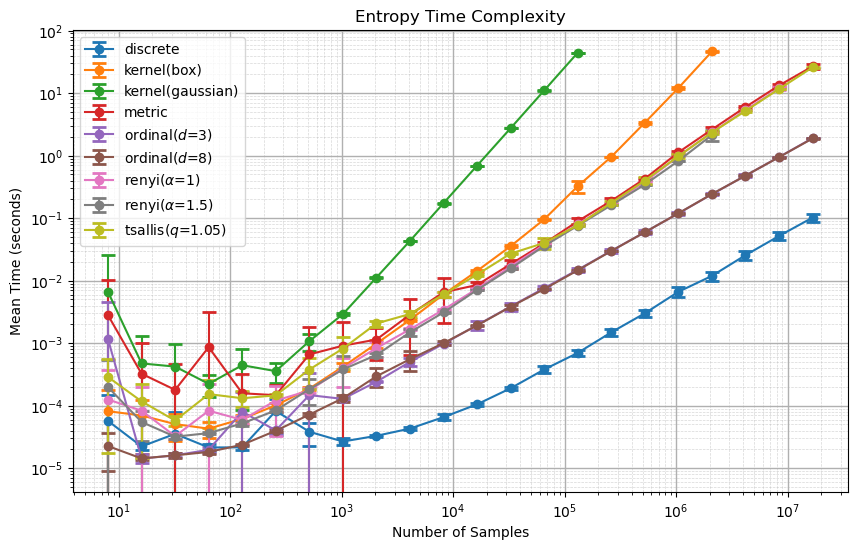

In [8]:
# Plot means against number of samples
plt.figure(figsize=(10, 6))
for key, combination in combinations.items():
    plt.errorbar(
        data_lengths,
        combination["h_means"],
        yerr=combination["h_stds"],
        marker="o",
        label=key,
        capsize=5,
        capthick=2,
    )
plt.xlabel("Number of Samples")
plt.ylabel("Mean Time (seconds)")
plt.title(f"Entropy Time Complexity")
plt.legend()
# log-log
plt.xscale("log")
plt.yscale("log")
# loglog grid
plt.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.grid(True, which="major", linestyle="-", linewidth=1)
plt.savefig("Time_Performance-Entropy.pdf", bbox_inches="tight")

For the datasets of a length larger than $10^4=10000$, the approaches show a linear trend.
As this is a log-log plot, this hints a power law relationship between the time complexity and the number of samples.
The gaussian kernel approach performs with the worst time complexity, while the discrete Shannon entropy approach performs with the best time complexity, orders of magnitude better and with a lower exponent.
Rényi and Tsallis have matching time complexities.

For the bias-corrected discrete entropy estimators, the time complexity is similar and scales between O(n) and O(n log n) and is between the runtime of Renyi/Tsallis but mostly not faster than the discrete approach. These approaches have been benchmarked separately and have been obtained in a modifying this notebook, but are not included in the computations of this notebook.

![Time Performance Entropy 0.5.0](./Time_Performance-Entropy-0.5.0_approaches.png)

### Mutual Information Computation

For MI, the computation happens analogously to H.

In [9]:
benchmark_max_time = 600
total_keys = len(combinations)

# Create a progress bar for the outer loop with customized widgets
widgets = [
    progressbar.DynamicMessage("key"),
    " |",
    progressbar.Bar(),
    " | ",
    progressbar.Percentage(),
    " (",
    progressbar.ETA(),
    ")",
]

with progressbar.ProgressBar(max_value=total_keys, widgets=widgets) as pbar:
    for i, (key, combination) in enumerate(combinations.items()):
        pbar.update(i, key=key)  # Update the progress bar with the current key

        data = data_mi if combination["approach"] != "discrete" else data_mi_discrete
        times_mi = [None] * len(data)

        for n in range(len(data)):
            t0 = time.time()
            times_mi[n] = benchmark_approach(
                im.entropy,
                data[n],
                approach=combination["approach"],
                **combination["kwargs"],
            )
            if time.time() - t0 > benchmark_max_time:
                # print(f"Time limit exceeded for {key} at index {n}")
                break

        means_mi = [
            np.mean(times_mi[n]) if times_mi[n] is not None else np.nan
            for n in range(len(data))
        ]
        stds_mi = [
            np.std(times_mi[n]) if times_mi[n] is not None else np.nan
            for n in range(len(data))
        ]
        combinations[key]["mi_means"] = means_mi
        combinations[key]["mi_times"] = times_mi
        combinations[key]["mi_stds"] = stds_mi

key: tsallis($q$=1.05) ||#############################| | 100% (Time:  3:33:58)3)


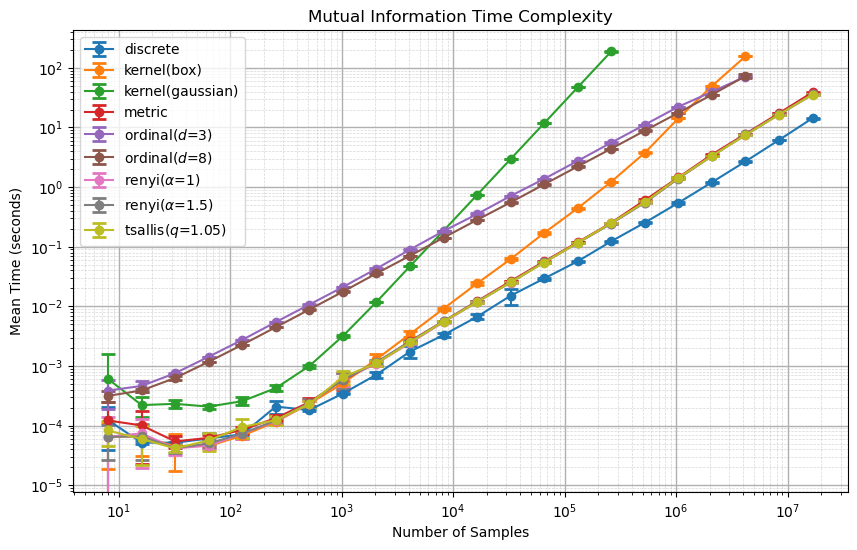

In [10]:
# Plotting the MI times against the number of samples
plt.figure(figsize=(10, 6))
for key, combination in combinations.items():
    plt.errorbar(
        data_lengths,
        combination["mi_means"],
        yerr=combination["mi_stds"],
        marker="o",
        label=key,
        capsize=5,
        capthick=2,
    )
plt.xlabel("Number of Samples")
plt.ylabel("Mean Time (seconds)")
plt.title(f"Mutual Information Time Complexity")
plt.legend()
# log-log
plt.xscale("log")
plt.yscale("log")
# loglog grid
plt.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.grid(True, which="major", linestyle="-", linewidth=1)
plt.savefig("Time_Performance-Mutual_Information.pdf", bbox_inches="tight")

### Transfer Entropy Comutation

TE also happens analogously to H and MI.

In [11]:
benchmark_max_time = 600
total_keys = len(combinations)

# Create a progress bar for the outer loop with customized widgets
widgets = [
    progressbar.DynamicMessage("key"),
    " |",
    progressbar.Bar(),
    " | ",
    progressbar.Percentage(),
    " (",
    progressbar.ETA(),
    ")",
]

with progressbar.ProgressBar(max_value=total_keys, widgets=widgets) as pbar:
    for i, (key, combination) in enumerate(combinations.items()):
        pbar.update(i, key=key)  # Update the progress bar with the current key

        data = data_te if combination["approach"] != "discrete" else data_te_discrete
        times_te = [None] * len(data)

        for n in range(len(data)):
            t0 = time.time()
            times_te[n] = benchmark_approach(
                im.entropy,
                data[n],
                approach=combination["approach"],
                **combination["kwargs"],
            )
            if time.time() - t0 > benchmark_max_time:
                # print(f"Time limit exceeded for {key} at index {n}")
                break

        means_te = [
            np.mean(times_te[n]) if times_te[n] is not None else np.nan
            for n in range(len(data))
        ]
        stds_te = [
            np.std(times_te[n]) if times_te[n] is not None else np.nan
            for n in range(len(data))
        ]
        combinations[key]["te_means"] = means_te
        combinations[key]["te_times"] = times_te
        combinations[key]["te_stds"] = stds_te

key: tsallis($q$=1.05) ||#############################| | 100% (Time:  3:49:52)9)


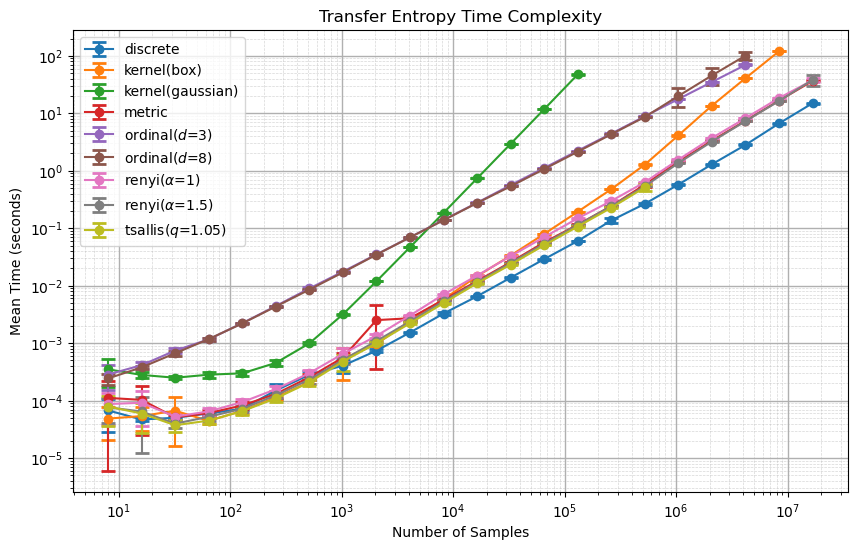

In [12]:
# Plotting the TE times against the number of samples
plt.figure(figsize=(10, 6))
for key, combination in combinations.items():
    plt.errorbar(
        data_lengths,
        combination["te_means"],
        yerr=combination["te_stds"],
        marker="o",
        label=key,
        capsize=5,
        capthick=2,
    )
plt.xlabel("Number of Samples")
plt.ylabel("Mean Time (seconds)")
plt.title(f"Transfer Entropy Time Complexity")
plt.legend()
# log-log
plt.xscale("log")
plt.yscale("log")
# loglog grid
plt.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.grid(True, which="major", linestyle="-", linewidth=1)
plt.savefig("Time_Performance-Transfer_Entropy.pdf", bbox_inches="tight")

## Comparison

Finally, we show the three results in a unified plot with shared y-axis for comparison.

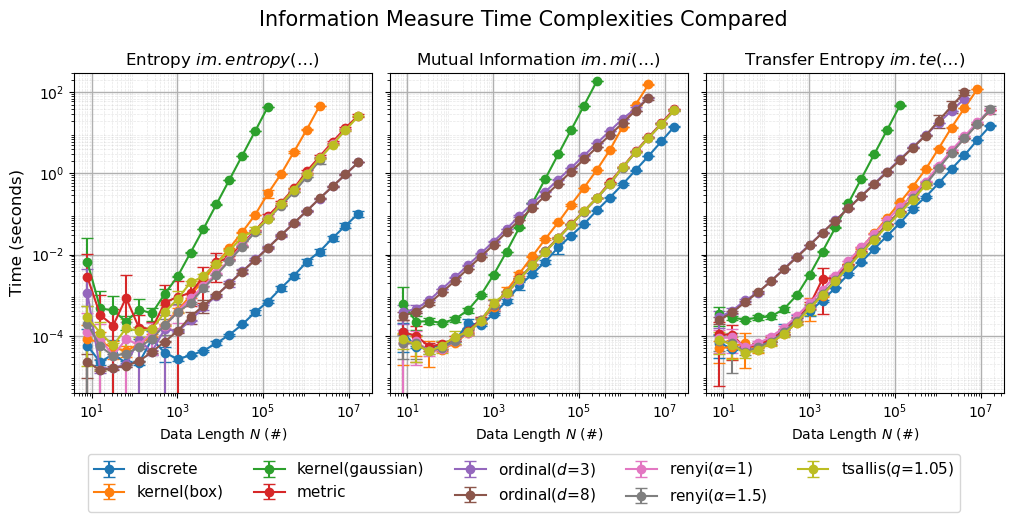

In [13]:
# Plot all three together
fig, axes = plt.subplots(ncols=3, figsize=(12, 4.5), sharey=True)
fig.subplots_adjust(wspace=0.06)

for key, combination in combinations.items():
    axes[0].errorbar(
        data_lengths,
        combination["h_means"],
        yerr=combination["h_stds"],
        marker="o",
        label=key,
        capsize=4,
        capthick=1,
    )
    axes[1].errorbar(
        data_lengths,
        combination["mi_means"],
        yerr=combination["mi_stds"],
        marker="o",
        label=key,
        capsize=4,
        capthick=1,
    )
    axes[2].errorbar(
        data_lengths,
        combination["te_means"],
        yerr=combination["te_stds"],
        marker="o",
        label=key,
        capsize=4,
        capthick=1,
    )
axes[0].set_title(r"Entropy $\it{im.entropy(…)}$")
axes[1].set_title(r"Mutual Information $\it{im.mi(…)}$")
axes[2].set_title(r"Transfer Entropy $\it{im.te(…)}$")
axes[0].set_ylabel("Time (seconds)", fontsize=12)
axes[0].set_ylim(4e-6, 3e2)
# Title for all
fig.suptitle("Information Measure Time Complexities Compared", fontsize=15, y=1.02)
for ax in axes:
    ax.set_xlabel(r"Data Length $N$ (#)")
    # ax.set_ylabel('Time (seconds)')
    ax.set_xscale("log")
    ax.set_yscale("log")
    # x ticks 10e1, e3, e5, e7
    ax.set_xticks([1e1, 1e3, 1e5, 1e7])
    # y ticks 10e-4, e-2, e0, e2
    ax.set_yticks([1e-4, 1e-2, 1e0, 1e2])
    ax.grid(True, which="major", linestyle="-", linewidth=1, axis="both")
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.3, axis="both")


# axes[2].legend(ncols=5, fontsize=6, bbox_to_anchor=(0.2, -0.2))
handles, labels = axes[0].get_legend_handles_labels()
# Adjust layout to make room for the legend
fig.subplots_adjust(bottom=0.17)
# Create a legend manually and place it below the subplots
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=5, fontsize=11
)

plt.savefig("Time_Performance.pdf", bbox_inches="tight")
plt.show()

## Backup and Load Data

If you want to look into our data, download it at {download}`time_data.pkl`.


In [14]:
import pickle

# Save data to pickle file
with open("time_data.pkl", "wb") as f:
    pickle.dump((data_lengths, combinations), f)

If you want to load it into this notebook, use the following code:

In [3]:
import pickle

# Load data from pickle file
with open("time_data.pkl", "rb") as f:
    data_lengths, combinations = pickle.load(f)